In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Topic: EX2 - Turbofan RUL Prediction
**Task**: Predict the remaining useful life (RUL) of turbofan engines based on given sensor data (time series data). It is a regression problem.
**Data**: Turbofan engine degradation simulation data (NASA) - [Link](https://data.nasa.gov/dataset/Turbofan-Engine-Degradation-Simulation-Data-Set/vrks-gjie). See also in the topic [introduction notebook](https://github.com/nina-prog/damage-propagation-modeling/blob/2fb8c1a1102a48d7abbf04e4031807790a913a99/notebooks/Turbofan%20remaining%20useful%20life%20Prediction.ipynb).

**Subtasks**:
1. Perform a deep **exploratory data analysis (EDA)** on the given data.
2. Implement a more efficient **sliding window method** for time series data analysis.
3. Apply **traditional machine learning methods** (SOTA) to predict the remaining useful life. Includes data preparation, feature extraction, feature selection, model selection, and model parameter optimization. -> 🎯 **Focus on this task** feature selection, model selection, and model parameter optimization.
4. Create **neural network models** to predict the remaining useful life. Includes different architectures like Convolutional Neural Networks (CNN), Recurrent Neural Networks (RNN), or Attention Models. Note: You can search for SOTA research papers and reproduce current state-of-the-art models.

# Imports + Settings

In [3]:
# third-party libraries
import pandas as pd
import numpy as np
import os
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tpot import TPOTRegressor

In [4]:
# source code
from src.data_loading import load_data, load_config
from src.data_cleaning import clean_data
from src.rolling_window_creator import RollingWindowDatasetCreator
from src.data_splitting import train_val_split_by_group

In [5]:
# settings
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set(rc={"figure.dpi": 100, 'savefig.dpi': 200})
sns.set_context('notebook')

np.random.seed(42)

# Paths

In [6]:
os.chdir("../")  # set working directory to root of project
os.getcwd() # check current working directory

'C:\\Users\\merti\\PycharmProjects\\damage-propagation-modeling'

In [7]:
PATH_TO_CONFIG = "configs/config.yaml"

# Load config

In [8]:
config = load_config(PATH_TO_CONFIG) # config is dict

# Dataset 1

**load data**

In [9]:
train_data, test_data, test_RUL_data = load_data(config_path=PATH_TO_CONFIG, dataset_num=1)

2024-05-31 20:43:43 [src.data_loading:43] [INFO] >>>> Loading data set 1...
2024-05-31 20:43:44 [src.data_loading:72] [INFO] >>>> Loaded raw data for dataset 1.
2024-05-31 20:43:44 [src.data_loading:73] [INFO] >>>> Train Data: (20631, 26)
2024-05-31 20:43:44 [src.data_loading:74] [INFO] >>>> Test Data: (13096, 26)
2024-05-31 20:43:44 [src.data_loading:75] [INFO] >>>> Test RUL Data: (100, 1)


**preprocess data**

In [31]:
# clean
cleaned_train, cleaned_test = clean_data(train_data, test_data, method='winsorize', ignore_columns=['UnitNumber', 'Cycle'], threshold_missing=0.5, threshold_corr=0.1, contamination=0.05)

2024-05-31 21:38:09 [src.data_cleaning:142] [INFO] >>>> Cleaning train and test data...
2024-05-31 21:38:09 [src.data_cleaning:145] [INFO] >>>> Formatting column types...
2024-05-31 21:38:09 [src.data_cleaning:77] [DEBUG] >>>> Found 0 categorical columns: []
2024-05-31 21:38:09 [src.data_cleaning:77] [DEBUG] >>>> Found 0 categorical columns: []
2024-05-31 21:38:09 [src.data_cleaning:150] [INFO] >>>> Filter and drop features based on missing values, single unique values, and target correlation...
2024-05-31 21:38:09 [src.data_cleaning:30] [DEBUG] >>>> Found 0 features with missing values above the threshold of 0.5.
2024-05-31 21:38:09 [src.data_cleaning:54] [DEBUG] >>>> Found 7 features with only a single unique value: ['Operation Setting 3', 'Sensor Measure 1', 'Sensor Measure 5', 'Sensor Measure 10', 'Sensor Measure 16', 'Sensor Measure 18', 'Sensor Measure 19']
2024-05-31 21:38:09 [src.data_cleaning:112] [DEBUG] >>>> Found 3 uncorrelated features with a correlation threshold of 0.1: 

In [13]:
%%time
# create rolling windows
creator = RollingWindowDatasetCreator(column_id="UnitNumber",
                                      column_sort="Cycle",
                                      max_window_size=config["preprocessing"]["max_window_size"],
                                      min_window_size=config["preprocessing"]["min_window_size"],
                                      feature_extraction_mode=config["preprocessing"]["feature_extraction_mode"],
                                      early_RUL=None)
X_train, y_train, X_test, y_test = creator.create_rolling_windows_datasets(cleaned_train, cleaned_test, test_RUL_data)

2024-05-31 21:03:26 [src.rolling_window_creator:132] [INFO] >>>> Creating rolling windows for train data...


Rolling: 100%|██████████| 37/37 [00:05<00:00,  7.14it/s]


2024-05-31 21:03:32 [src.rolling_window_creator:140] [INFO] >>>> Extracting features for train data...


Feature Extraction: 100%|██████████| 40/40 [02:16<00:00,  3.41s/it]


2024-05-31 21:06:24 [src.rolling_window_creator:148] [INFO] >>>> Calculating target for train data...
2024-05-31 21:06:24 [src.rolling_window_creator:132] [INFO] >>>> Creating rolling windows for test data...


Rolling: 100%|██████████| 38/38 [00:04<00:00,  9.44it/s]


2024-05-31 21:06:28 [src.rolling_window_creator:140] [INFO] >>>> Extracting features for test data...


Feature Extraction: 100%|██████████| 40/40 [00:03<00:00, 13.04it/s]


2024-05-31 21:06:31 [src.rolling_window_creator:176] [INFO] >>>> Datasets created successfully.
2024-05-31 21:06:31 [src.rolling_window_creator:177] [INFO] >>>> Shape of X_train: (19731, 720)
2024-05-31 21:06:31 [src.rolling_window_creator:178] [INFO] >>>> Shape of y_train: (19731, 1)
2024-05-31 21:06:31 [src.rolling_window_creator:179] [INFO] >>>> Shape of X_test: (100, 720)
2024-05-31 21:06:31 [src.rolling_window_creator:180] [INFO] >>>> Shape of y_test: (100, 1)
CPU times: total: 1min 10s
Wall time: 3min 5s


In [14]:
# split
# using a GroupShuffleSplit, to make sure that the same unit is not in both train and test set, to avoid data leakage and make the model more robust
X_train, X_val, y_train, y_val  = train_val_split_by_group(X=X_train, y=y_train, group="UnitNumber", test_size=0.2)

2024-05-31 21:09:55 [src.data_splitting:65] [INFO] >>>> Split data successfully.
2024-05-31 21:09:55 [src.data_splitting:66] [INFO] >>>> Train set contains 80 different engines --> in total 15734
2024-05-31 21:09:55 [src.data_splitting:67] [INFO] >>>> Validation set contains 20 different engines --> in total 3997


In [26]:
# make sure all have same column names
assert set(X_train.columns) == set(X_val.columns) == set(X_test.columns)
# make sure all have same column order
X_train = X_train[X_test.columns]
X_val = X_val[X_test.columns]

In [27]:
# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

**select features**

In [149]:
k = 50

In [150]:
# 1) univariate feature selection (supervised, filter method)
selector = SelectKBest(score_func=f_regression, k=k)
X_train_selected = selector.fit_transform(X_train_scaled, y_train.to_numpy().flatten())
# get names of selected features
kbest_selected_features = [col for i, col in enumerate(X_train.columns) if selector.get_support()[i]]
kbest_selected_features

['Sensor Measure 2__quantile__q_0.5',
 'Sensor Measure 2__quantile__q_0.9',
 'Sensor Measure 2__mean',
 'Sensor Measure 2__median',
 'Sensor Measure 3__quantile__q_0.1',
 'Sensor Measure 3__quantile__q_0.5',
 'Sensor Measure 3__quantile__q_0.9',
 'Sensor Measure 3__mean',
 'Sensor Measure 3__median',
 'Sensor Measure 4__quantile__q_0.1',
 'Sensor Measure 4__quantile__q_0.5',
 'Sensor Measure 4__quantile__q_0.9',
 'Sensor Measure 4__agg_linear_trend__attr_"intercept"__chunk_len_10__f_agg_"mean"',
 'Sensor Measure 4__maximum',
 'Sensor Measure 4__mean',
 'Sensor Measure 4__median',
 'Sensor Measure 7__quantile__q_0.1',
 'Sensor Measure 7__quantile__q_0.5',
 'Sensor Measure 7__mean',
 'Sensor Measure 7__median',
 'Sensor Measure 11__quantile__q_0.1',
 'Sensor Measure 11__quantile__q_0.5',
 'Sensor Measure 11__quantile__q_0.9',
 'Sensor Measure 11__maximum',
 'Sensor Measure 11__mean',
 'Sensor Measure 11__median',
 'Sensor Measure 12__quantile__q_0.1',
 'Sensor Measure 12__quantile__q_0.5

In [117]:
%%time
# 2) feature importance from Random Forest (supervised, intrinsic method)
rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train.to_numpy().flatten())

InvalidIndexError: (slice(None, None, None), array([549, 357, 597, 290, 309,  21, 330,  42, 570, 328,  69, 674,  40,
       288, 117, 233, 520,  41,  90, 138, 338, 136, 432,  88, 521, 364,
       289, 103, 395, 329, 261, 523, 363, 530,  98, 194, 376, 282, 347,
       528, 331, 192, 481, 713, 482,   2, 568, 672, 425, 665], dtype=int64))

In [120]:
# get feature importance scores
feature_importances = rf.feature_importances_
# select top k features
top_k_indices = np.argsort(feature_importances)[::-1][:k]
# get names of selected features
rf_selected_features = [col for i, col in enumerate(X_train.columns) if i in top_k_indices]
rf_selected_features

['Sensor Measure 2__quantile__q_0.9',
 'Sensor Measure 2__fft_coefficient__attr_"real"__coeff_0',
 'Sensor Measure 2__maximum',
 'Sensor Measure 2__minimum',
 'Sensor Measure 2__mean',
 'Sensor Measure 3__fft_coefficient__attr_"real"__coeff_0',
 'Sensor Measure 3__maximum',
 'Sensor Measure 3__mean',
 'Sensor Measure 4__quantile__q_0.9',
 'Sensor Measure 4__autocorrelation__lag_3',
 'Sensor Measure 4__fft_coefficient__attr_"real"__coeff_0',
 'Sensor Measure 4__maximum',
 'Sensor Measure 4__mean',
 'Sensor Measure 7__quantile__q_0.1',
 'Sensor Measure 7__quantile__q_0.9',
 'Sensor Measure 7__minimum',
 'Sensor Measure 8__fft_coefficient__attr_"real"__coeff_0',
 'Sensor Measure 8__mean',
 'Sensor Measure 9__quantile__q_0.1',
 'Sensor Measure 9__quantile__q_0.5',
 'Sensor Measure 9__quantile__q_0.9',
 'Sensor Measure 9__fft_coefficient__attr_"real"__coeff_0',
 'Sensor Measure 9__maximum',
 'Sensor Measure 9__minimum',
 'Sensor Measure 9__mean',
 'Sensor Measure 9__median',
 'Sensor Measur

In [148]:
# compare the selected features
print(f"{len(set(kbest_selected_features) & set(rf_selected_features))} Features selected by SelectKBest and RandomForest")
print(f"{len(set(kbest_selected_features) - set(rf_selected_features))} Features only selected by SelectKBest.")
print(f"{len(set(rf_selected_features) - set(kbest_selected_features))} Features only selected by RandomForest.")

14 Features selected by SelectKBest and RandomForest
36 Features only selected by SelectKBest.
36 Features only selected by RandomForest.


In [151]:
# select features based on Random Forest feature importance
X_train_selected = X_train_scaled[:, top_k_indices]
X_val_selected = X_val_scaled[:, top_k_indices]
X_test_selected = X_test_scaled[:, top_k_indices]

In [155]:
# check shapes of X and y
print("X: ", X_train_selected.shape, X_val_selected.shape, X_test_selected.shape)
print("y: ", y_train.shape, y_val.shape, y_test.shape)

X:  (16054, 50) (4077, 50) (100, 50)
y:  (16054, 1) (4077, 1) (100, 1)


**train**
Using an auto ml library like TPOT here. It technically does not support categorical features or natural language processing, this is no problem for our dataset since it only contains numerical features.

In [167]:
%%time
# initialize and fit TPOT regressor
tpot = TPOTRegressor(generations=10, population_size=20, verbosity=2, random_state=42)
tpot.fit(features=X_train_selected, target=y_train.to_numpy().flatten(), groups=X_train.index.get_level_values("UnitNumber").values)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1759.9776783949746

Generation 2 - Current best internal CV score: -1756.737430891164

Generation 3 - Current best internal CV score: -1756.737430891164

Generation 4 - Current best internal CV score: -1756.5964625891017

Generation 5 - Current best internal CV score: -1699.1765925929358

Best pipeline: XGBRegressor(RidgeCV(input_matrix), learning_rate=0.1, max_depth=2, min_child_weight=19, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.7000000000000001, verbosity=0)
CPU times: total: 5min 56s
Wall time: 10min 10s


TPOTRegressor(generations=5, population_size=20, random_state=42, verbosity=2)

In [168]:
# evaluate and summarize in dataframe
y_val_pred = tpot.predict(X_val_selected)
y_test_pred = tpot.predict(X_test_selected)

results = pd.DataFrame(columns=["Metric", "Train", "Validation", "Test"])
results.loc[len(results)] = ["MSE", mean_squared_error(y_train, tpot.predict(X_train_selected)), mean_squared_error(y_val, y_val_pred), mean_squared_error(y_test, y_test_pred)]
results.loc[len(results)] = ["MAE", mean_absolute_error(y_train, tpot.predict(X_train_selected)), mean_absolute_error(y_val, y_val_pred), mean_absolute_error(y_test, y_test_pred)]
results.loc[len(results)] = ["R2", r2_score(y_train, tpot.predict(X_train_selected)), r2_score(y_val, y_val_pred), r2_score(y_test, y_test_pred)]
results


,Metric,Train,Validation,Test
0,MSE,1136.338502,1827.901249,1783.002717
1,MAE,24.615858,28.414208,35.749060
2,R2,0.747983,0.622512,-0.032506


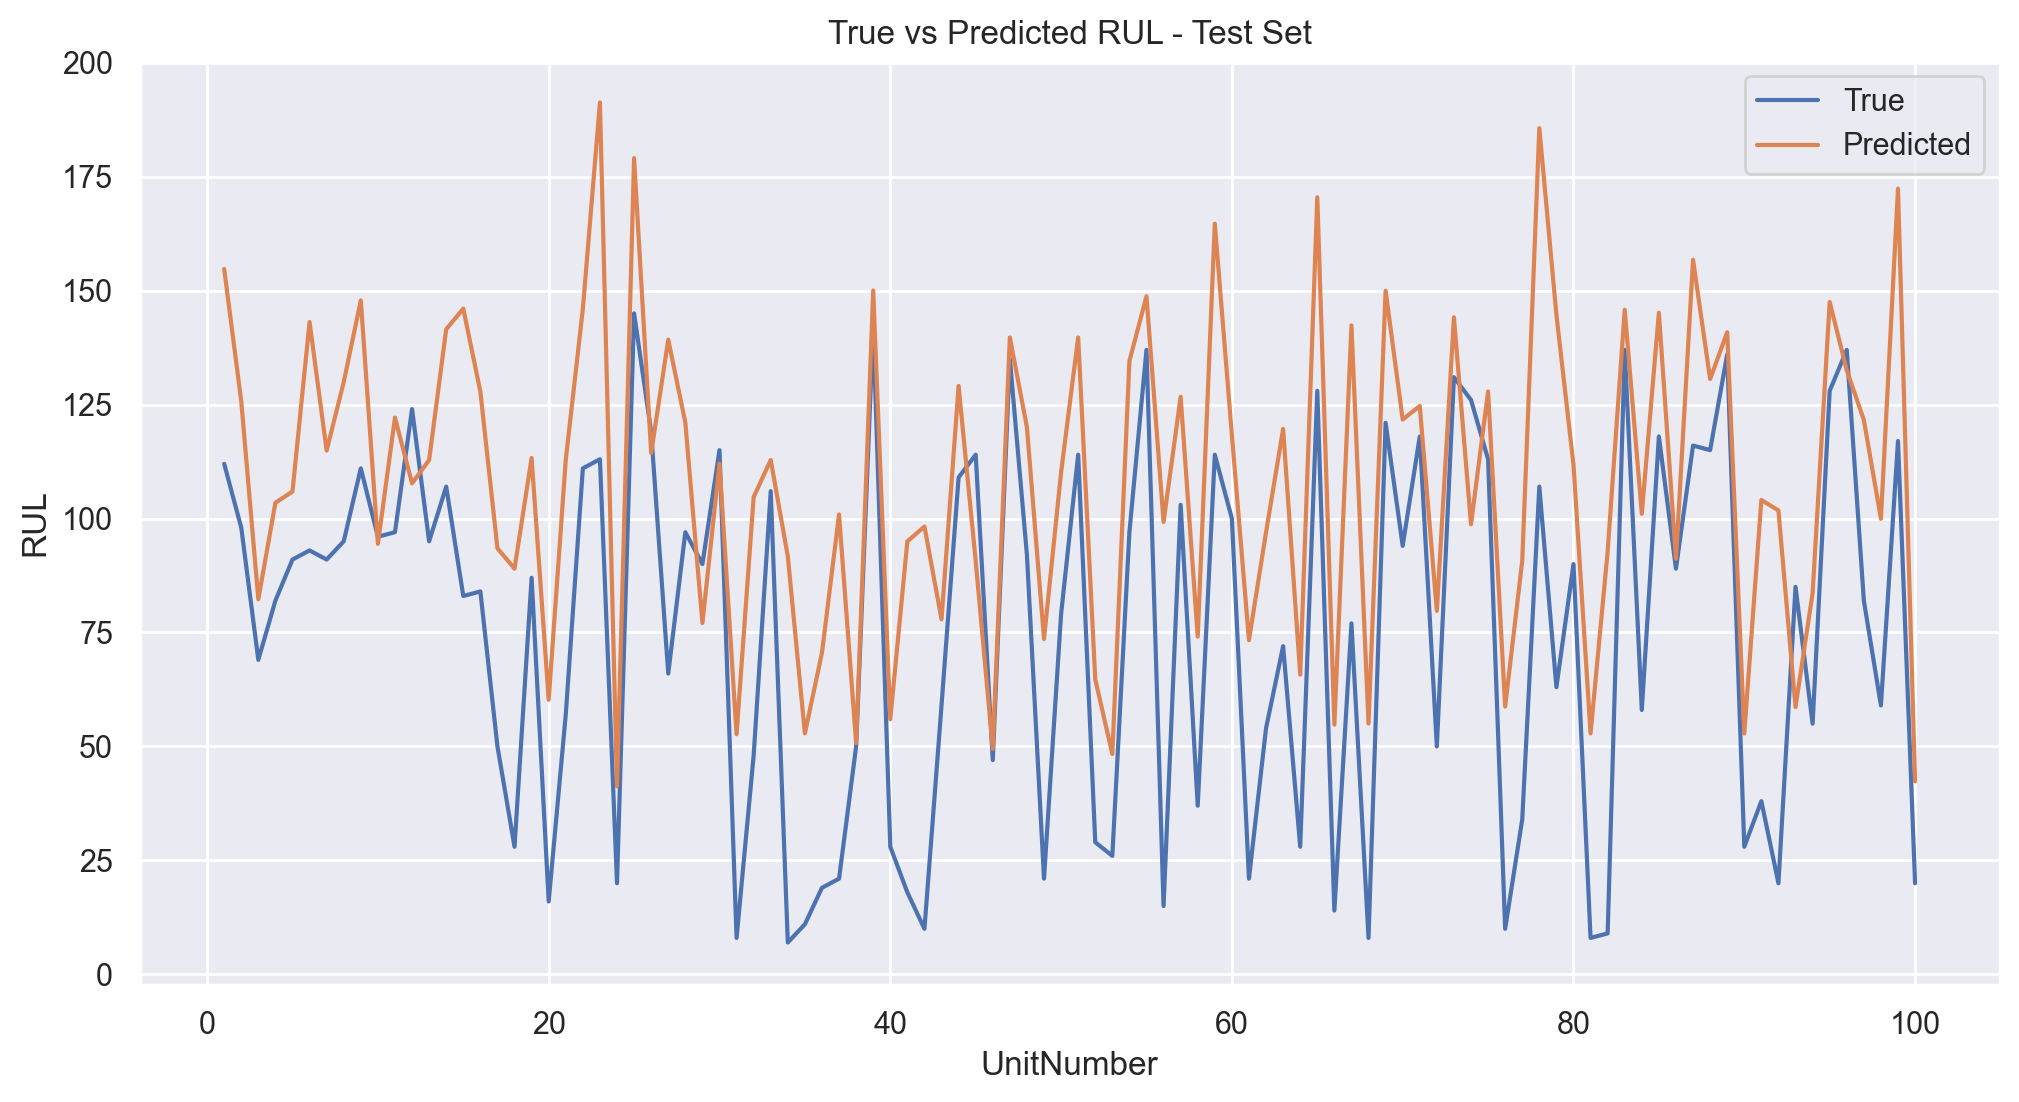

In [187]:
# compare predict and true values of test set with sns
fig = plt.figure(figsize=(12, 6))
sns.lineplot(x=y_test.index.get_level_values("UnitNumber").values, y=y_test.values.flatten(), label="True")
sns.lineplot(x=y_test.index.get_level_values("UnitNumber").values, y=y_test_pred, label="Predicted")
plt.title("True vs Predicted RUL - Test Set")
plt.xlabel("UnitNumber")
plt.ylabel("RUL")
plt.legend()
plt.show()
